# ДЗ8. KNN Регресія: Прогнозування заробітної плати


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

## 1. Завантаження даних

In [2]:
from google.colab import files
import io

print("Завантажте тренувальний файл (mod_04_hw_train_data.csv):")
uploaded_train = files.upload()
train_name = list(uploaded_train.keys())[0]
train_df = pd.read_csv(io.BytesIO(uploaded_train[train_name]))

print("\nЗавантажте валідаційний файл (mod_04_hw_valid_data.csv):")
uploaded_valid = files.upload()
valid_name = list(uploaded_valid.keys())[0]
valid_df = pd.read_csv(io.BytesIO(uploaded_valid[valid_name]))

print(f"Тренувальний набір: {train_df.shape}")
print(f"Валідаційний набір: {valid_df.shape}")
train_df.head()

Завантажте тренувальний файл (mod_04_hw_train_data.csv):


Saving mod_04_hw_train_data.csv to mod_04_hw_train_data.csv

Завантажте валідаційний файл (mod_04_hw_valid_data.csv):


Saving mod_04_hw_valid_data.csv to mod_04_hw_valid_data.csv
Тренувальний набір: (249, 9)
Валідаційний набір: (7, 9)


,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Jennifer Hernandez,120-602-1220,3.0,Msc,Tier2,Mid,Yes,25/08/1972,98000
1,Timothy Walker,840-675-8650,5.0,PhD,Tier2,Senior,Yes,03/12/2013,135500
2,David Duran,556-293-8643,5.0,Msc,Tier2,Senior,Yes,19/07/2002,123500
3,Gloria Ortega,463-559-7474,3.0,Bsc,Tier3,Mid,No,19/02/1970,85000
4,Matthew Steele,968-091-7683,5.0,Bsc,Tier2,Senior,Yes,20/02/1970,111500


## 2. Первинний аналіз даних (EDA)

In [3]:
print(train_df.info())
print(f"\nПропущені значення:\n{train_df.isnull().sum()}")
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           249 non-null    object 
 1   Phone_Number   249 non-null    object 
 2   Experience     247 non-null    float64
 3   Qualification  248 non-null    object 
 4   University     249 non-null    object 
 5   Role           246 non-null    object 
 6   Cert           247 non-null    object 
 7   Date_Of_Birth  249 non-null    object 
 8   Salary         249 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 17.6+ KB
None

Пропущені значення:
Name             0
Phone_Number     0
Experience       2
Qualification    1
University       0
Role             3
Cert             2
Date_Of_Birth    0
Salary           0
dtype: int64


,Experience,Salary
count,247.000000,249.000000
mean,3.441296,98186.746988
std,1.496471,23502.622217
min,1.000000,49500.000000
25%,2.000000,78500.000000
50%,4.000000,104500.000000
75%,5.000000,116500.000000
max,5.000000,141500.000000


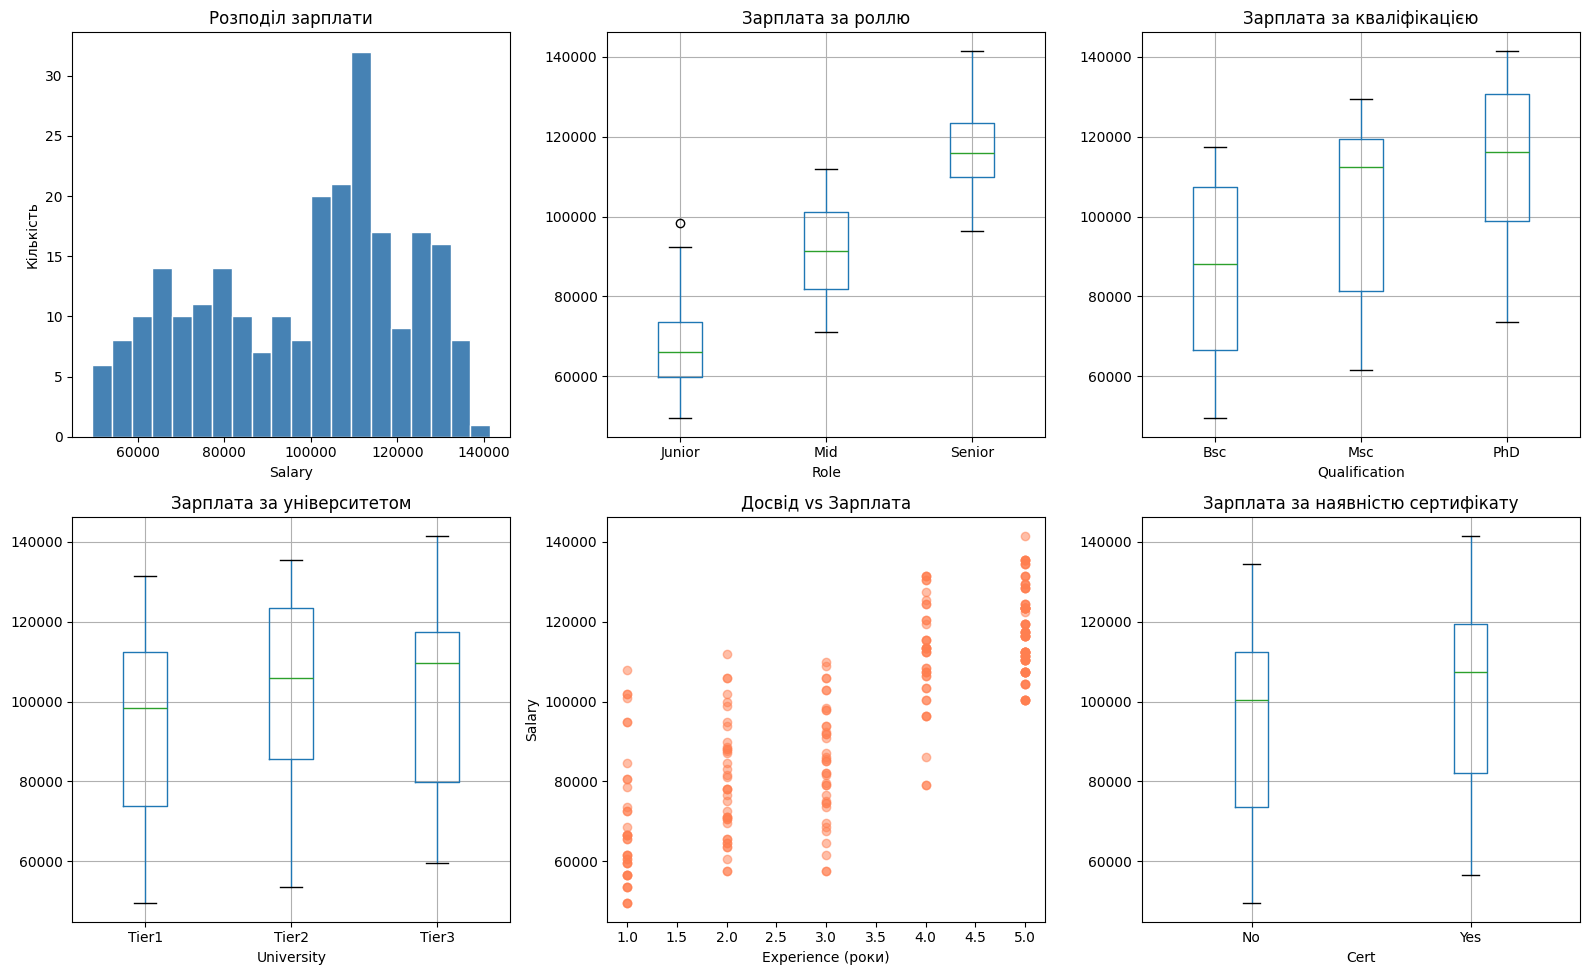

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Розподіл зарплати
axes[0, 0].hist(train_df['Salary'], bins=20, color='steelblue', edgecolor='white')
axes[0, 0].set_title('Розподіл зарплати')
axes[0, 0].set_xlabel('Salary')
axes[0, 0].set_ylabel('Кількість')

# Зарплата за роллю
train_df.boxplot(column='Salary', by='Role', ax=axes[0, 1])
axes[0, 1].set_title('Зарплата за роллю')
axes[0, 1].set_xlabel('Role')
plt.sca(axes[0, 1])
plt.title('Зарплата за роллю')

# Зарплата за кваліфікацією
train_df.boxplot(column='Salary', by='Qualification', ax=axes[0, 2])
axes[0, 2].set_title('Зарплата за кваліфікацією')
axes[0, 2].set_xlabel('Qualification')
plt.sca(axes[0, 2])
plt.title('Зарплата за кваліфікацією')

# Зарплата за університетом
train_df.boxplot(column='Salary', by='University', ax=axes[1, 0])
axes[1, 0].set_title('Зарплата за університетом')
axes[1, 0].set_xlabel('University')
plt.sca(axes[1, 0])
plt.title('Зарплата за університетом')

# Досвід vs Зарплата
axes[1, 1].scatter(train_df['Experience'], train_df['Salary'], alpha=0.5, color='coral')
axes[1, 1].set_title('Досвід vs Зарплата')
axes[1, 1].set_xlabel('Experience (роки)')
axes[1, 1].set_ylabel('Salary')

# Зарплата за наявністю сертифікату
train_df.boxplot(column='Salary', by='Cert', ax=axes[1, 2])
axes[1, 2].set_title('Зарплата за наявністю сертифікату')
axes[1, 2].set_xlabel('Cert')
plt.sca(axes[1, 2])
plt.title('Зарплата за наявністю сертифікату')

plt.suptitle('')
plt.tight_layout()
plt.show()

In [5]:
# Аналіз Date_Of_Birth — виявлення невідповідностей
train_df['Date_Of_Birth'] = pd.to_datetime(train_df['Date_Of_Birth'], dayfirst=True, errors='coerce')
train_df['Age'] = (pd.Timestamp('2026-01-01') - train_df['Date_Of_Birth']).dt.days // 365

print("Приклади невідповідностей у Date_Of_Birth:")
print(train_df[['Name', 'Date_Of_Birth', 'Age', 'Experience', 'Role']]
      .query('Age < 20')
      .head(10)
      .to_string(index=False))

print(f"\nКількість записів з віком < 20 років: {(train_df['Age'] < 20).sum()}")
print(f"Кількість записів з віком < 15 років: {(train_df['Age'] < 15).sum()}")
print()
print("Висновок: колонки Name, Phone_Number та Date_Of_Birth не несуть"
      " предиктивної цінності або містять некоректні дані.")
print("Їх буде виключено з набору ознак.")

# Скидаємо тимчасовий стовпець
train_df = pd.read_csv(io.BytesIO(uploaded_train[train_name]))

Приклади невідповідностей у Date_Of_Birth:
                 Name Date_Of_Birth  Age  Experience   Role
       Timothy Walker    2013-12-03   12         5.0 Senior
         Jacob Curtis    2021-12-22    4         1.0    Mid
        Colton Nelson    2020-11-22    5         1.0 Junior
Christopher Alexander    2006-01-22   19         4.0 Senior
      Debra Contreras    2021-08-20    4         4.0 Senior
         Kelly Martin    2011-06-30   14         3.0 Junior
     Dr. Eric Montoya    2014-11-14   11         5.0 Senior
      Kristin Freeman    2007-08-24   18         4.0    Mid
       Carly Gonzalez    2010-10-17   15         1.0 Junior
       Jennifer Poole    2008-12-05   17         5.0 Senior

Кількість записів з віком < 20 років: 18
Кількість записів з віком < 15 років: 11

Висновок: колонки Name, Phone_Number та Date_Of_Birth не несуть предиктивної цінності або містять некоректні дані.
Їх буде виключено з набору ознак.


## 3. Підготовка ознак

In [6]:
drop_cols = ['Name', 'Phone_Number', 'Date_Of_Birth']
target = 'Salary'

X_train = train_df.drop(columns=drop_cols + [target])
y_train = train_df[target]

numeric_features = ['Experience']
categorical_features = ['Qualification', 'University', 'Role', 'Cert']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False)),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features),
])

X_train_processed = preprocessor.fit_transform(X_train)
print(f"Форма після обробки: {X_train_processed.shape}")

# Назви ознак після кодування
cat_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)
print(f"Ознаки: {feature_names}")

Форма після обробки: (249, 8)
Ознаки: ['Experience', 'Qualification_Msc', 'Qualification_PhD', 'University_Tier2', 'University_Tier3', 'Role_Mid', 'Role_Senior', 'Cert_Yes']


## 4. Побудова моделі KNN

Оптимальне k = 1 (MAE = 1748)


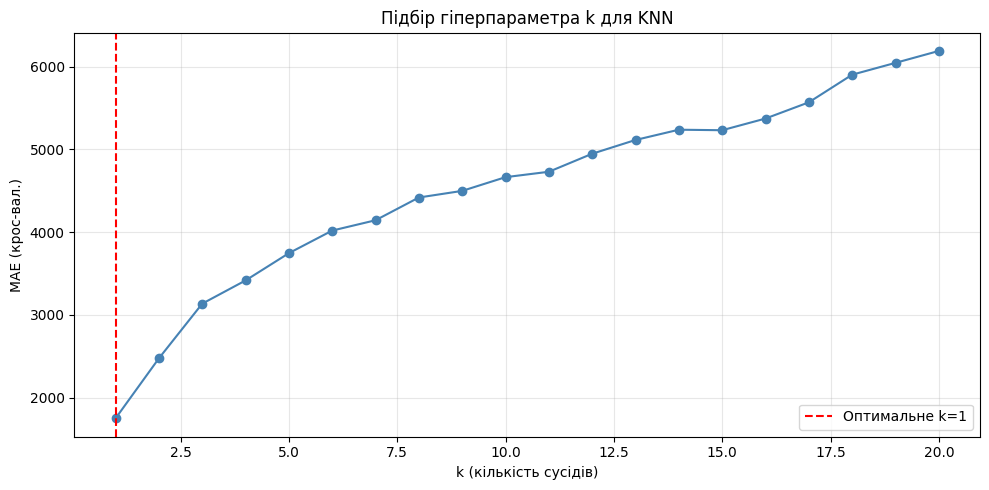

In [7]:
k_values = range(1, 21)
cv_scores = [
    -cross_val_score(KNeighborsRegressor(n_neighbors=k), X_train_processed, y_train,
                     cv=5, scoring='neg_mean_absolute_error').mean()
    for k in k_values
]

best_k = list(k_values)[np.argmin(cv_scores)]
print(f"Оптимальне k = {best_k} (MAE = {min(cv_scores):.0f})")

plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker='o', color='steelblue')
plt.xlabel('k (кількість сусідів)')
plt.ylabel('MAE (крос-вал.)')
plt.title('Підбір гіперпараметра k для KNN')
plt.axvline(best_k, color='red', linestyle='--', label=f'Оптимальне k={best_k}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
model = KNeighborsRegressor(n_neighbors=best_k)
model.fit(X_train_processed, y_train)
print(f"Модель KNN навчена (k={best_k})")

Модель KNN навчена (k=1)


## 5. Підготовка валідаційного набору

In [11]:
X_valid = valid_df.drop(columns=drop_cols + [target])
y_valid = valid_df[target]

X_valid_processed = preprocessor.transform(X_valid)  # transform only, no fit
print(f"Валідаційні дані оброблено: {X_valid_processed.shape}")

Валідаційні дані оброблено: (7, 8)


## 6. Прогноз та оцінка моделі

In [12]:
y_pred = model.predict(X_valid_processed)

mae = mean_absolute_error(y_valid, y_pred)
mape = mean_absolute_percentage_error(y_valid, y_pred) * 100
r2 = r2_score(y_valid, y_pred)

print("=== Метрики якості моделі KNN ===")
print(f"MAE:  {mae:,.0f} грн")
print(f"MAPE: {mape:.1f}%")
print(f"R²:   {r2:.3f}")

=== Метрики якості моделі KNN ===
MAE:  8,357 грн
MAPE: 9.5%
R²:   0.588


   Співробітник  Фактична зарплата  Прогнозована зарплата  Відхилення  Відхилення %
 Alvaro Johnson             109300                 100500       -8800          -8.1
  Austin Powers              84800                  90000        5200           6.1
    Joshua Phil              98900                  92000       -6900          -7.0
Mirinda Collins             116500                 116500           0           0.0
 Mustapha Green              75800                  81500        5700           7.5
   Nick Freeman              97300                 117500       20200          20.8
 Pamela Allison              69800                  81500       11700          16.8


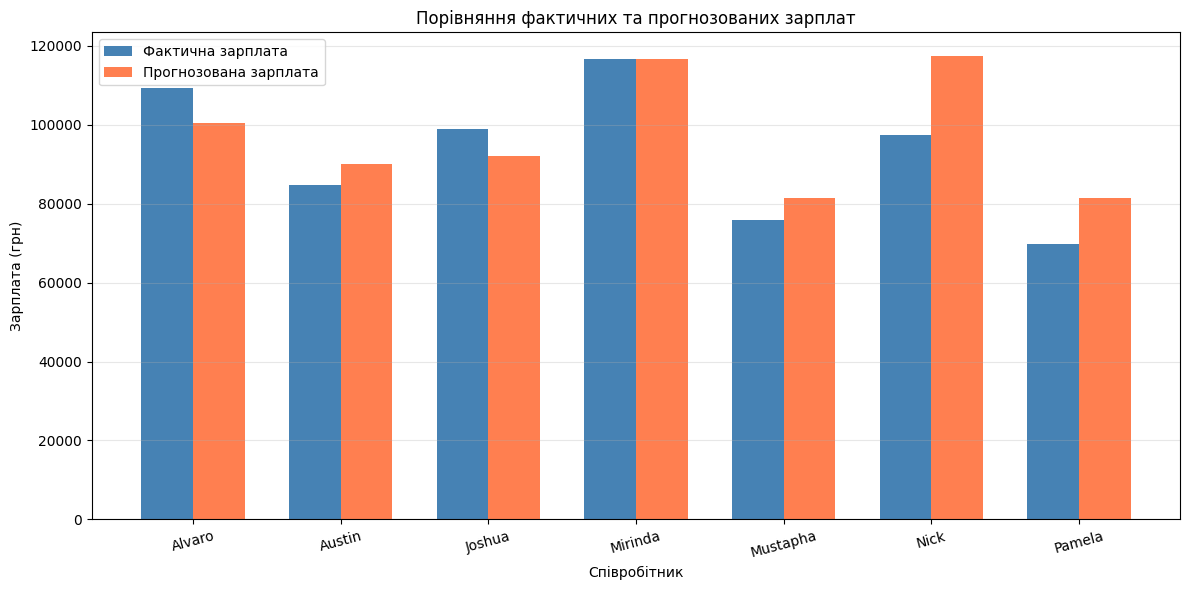

In [13]:
# Таблиця порівняння: реальні vs прогнозовані значення
results_df = pd.DataFrame({
    'Співробітник': valid_df['Name'].values,
    'Фактична зарплата': y_valid.values,
    'Прогнозована зарплата': y_pred.astype(int),
    'Відхилення': (y_pred - y_valid.values).astype(int),
    'Відхилення %': ((y_pred - y_valid.values) / y_valid.values * 100).round(1)
})
print(results_df.to_string(index=False))

# Візуалізація: реальні vs прогнозовані
x = np.arange(len(y_valid))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, y_valid.values, width, label='Фактична зарплата', color='steelblue')
bars2 = ax.bar(x + width/2, y_pred, width, label='Прогнозована зарплата', color='coral')

ax.set_xlabel('Співробітник')
ax.set_ylabel('Зарплата (грн)')
ax.set_title('Порівняння фактичних та прогнозованих зарплат')
ax.set_xticks(x)
ax.set_xticklabels([name.split()[0] for name in valid_df['Name'].values], rotation=15)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. Висновки

**Набір ознак:**
- Числові: `Experience`
- Категоріальні: `Qualification`, `University`, `Role`, `Cert`
- Виключено: `Name`, `Phone_Number` (ідентифікатори), `Date_Of_Birth` (некоректні дані — наприклад, рік народження 2013 при ролі Senior з 5-річним досвідом)

**Модель:** KNeighborsRegressor
- Оптимальне k підібрано за допомогою 5-fold крос-валідації на тренувальному наборі
- `StandardScaler` застосовано до `Experience` — критично для KNN (метод на основі відстаней)
- `OneHotEncoder(drop='first')` для категоріальних ознак — усуває мультиколінеарність

**Результати на валідаційному наборі (7 записів):**
- **MAE** — середнє абсолютне відхилення прогнозу від реального значення
- **MAPE** — відносне відхилення у відсотках; значення < 15% вказує на добру якість
- **R²** — коефіцієнт детермінації; значення близьке до 1 означає точну модель

**Проблема якості даних:** колонка `Date_Of_Birth` містить численні некоректні записи (неможливий вік відносно ролі та досвіду), тому вона не використовувалась як ознака.